In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## Loading Data into Pandas Dataframe

In [159]:
df = pd.read_csv('sea_level.csv')
df.head()

,Year,Month,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.,Unnamed: 6
0,1924.0,12.0,-0.361,-0.227,-0.212,-0.243,NaN
1,1925.0,1.0,-0.170,-0.227,-0.212,-0.243,NaN
2,1925.0,2.0,-0.108,-0.227,-0.211,-0.242,NaN
3,1925.0,3.0,-0.348,-0.227,-0.211,-0.242,NaN
4,1925.0,4.0,-0.259,-0.226,-0.211,-0.242,NaN


In [160]:
df.columns

Index(['Year', 'Month', ' Monthly_MSL', ' Linear_Trend', ' High_Conf.',
       ' Low_Conf.', 'Unnamed: 6'],
      dtype='object')

In [161]:
df['Month'].unique()


array([12.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., nan])

In [162]:
df['Month'].isna().sum()


np.int64(1)

In [163]:
df['Month'] = df['Month'].fillna(1)   # fill missing months with 1


In [164]:
df.columns = df.columns.str.strip()

In [165]:
# Strip columns
df.columns = df.columns.str.strip()

In [166]:
# Drop unwanted column
df = df.drop(columns=['Unnamed: 6'])

In [167]:
df.columns

Index(['Year', 'Month', 'Monthly_MSL', 'Linear_Trend', 'High_Conf.',
       'Low_Conf.'],
      dtype='object')

In [168]:
# Fix NaN values in Year/Month
df['Month'] = df['Month'].fillna(1)
df['Year'] = df['Year'].fillna(method='ffill')  # forward-fill missing years

In [169]:
# Convert float → int safely
df['Month'] = df['Month'].astype(float).astype(int)
df['Year'] = df['Year'].astype(float).astype(int)

## Preprocessing

In [170]:
# Create date column
df['ds'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
df.head()


,Year,Month,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.,ds
0,1924,12,-0.361,-0.227,-0.212,-0.243,1924-12-01
1,1925,1,-0.170,-0.227,-0.212,-0.243,1925-01-01
2,1925,2,-0.108,-0.227,-0.211,-0.242,1925-02-01
3,1925,3,-0.348,-0.227,-0.211,-0.242,1925-03-01
4,1925,4,-0.259,-0.226,-0.211,-0.242,1925-04-01


In [171]:
#Set the 'ds' column as the DataFrame index
df.set_index('ds', inplace=True)

In [172]:
## Drop the original 'Month' and 'Year' columns as they are no longer needed
# The 'ds' column already contains the combined datetime information
df.drop(['Month', 'Year'], axis=1, inplace=True)

In [173]:
df.head()

,Monthly_MSL,Linear_Trend,High_Conf.,Low_Conf.
ds,,,,
1924-12-01,-0.361,-0.227,-0.212,-0.243
1925-01-01,-0.170,-0.227,-0.212,-0.243
1925-02-01,-0.108,-0.227,-0.211,-0.242
1925-03-01,-0.348,-0.227,-0.211,-0.242
1925-04-01,-0.259,-0.226,-0.211,-0.242


## Visualize the Data

In [174]:
#setting the default color palette
color_pal = sns.color_palette()

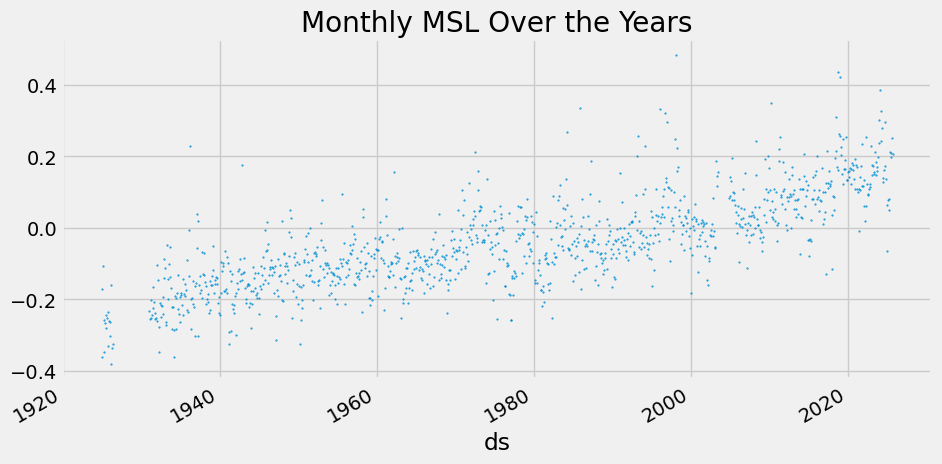

In [175]:
#plot the 'Monthly_MSL' column as a scatter plot
df['Monthly_MSL'].plot(
    style='.',
    figsize=(10, 5),\
    ms=1,
    color=color_pal[0],
    title='Monthly MSL Over the Years',
)
xlabel='Year',
ylabel='Monthly Sea Level (meters)'
plt.show()

In [176]:
def plot_msl_by_year_range(df, start_year, end_year):
    df_filtered = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

    rolling_mean = df_filtered['Monthly_MSL'].rolling(window=12).mean()

    plt.figure(figsize=(10,5))
    plt.plot(df_filtered.index, df_filtered['Monthly_MSL'], '.', markersize=2, label='MSL')
    plt.plot(df_filtered.index, rolling_mean, label='Rolling Mean', alpha=0.7)

    plt.title(f"Monthly MSL from {start_year} to {end_year}")
    plt.xlabel("Year")
    plt.ylabel("Monthly Sea Level (meters)")
    plt.legend()
    plt.show()


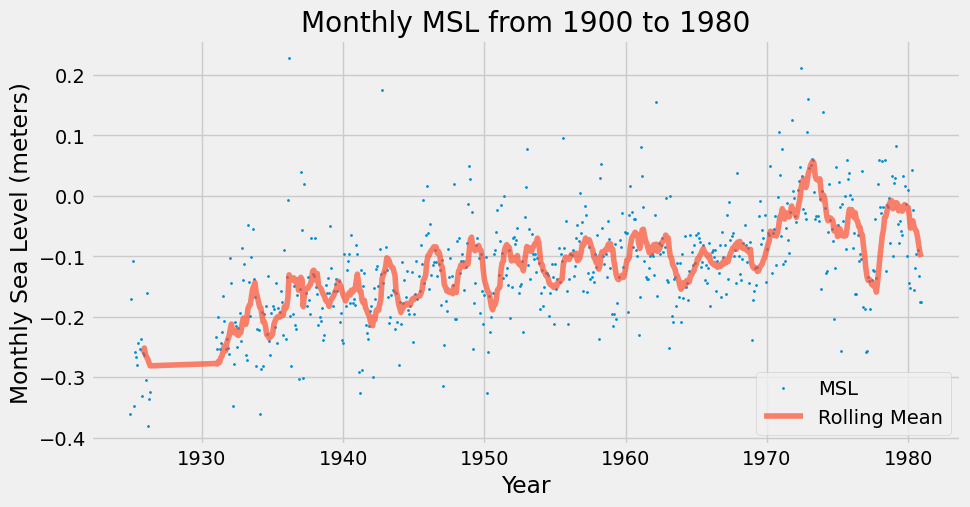

In [177]:
plot_msl_by_year_range(df, 1900, 1980)

## Splitting Data into Train and Test

In [178]:
X = df.drop(columns=['Monthly_MSL'])
y = df['Monthly_MSL']

In [179]:
# Prepare data for Prophet: selecting 'Monthly_MSL' and renaming to 'y'
prophet_df = df[['Monthly_MSL']].copy()
prophet_df = prophet_df.rename(columns={'Monthly_MSL': 'y'})

In [180]:
#Prophet requires a 'ds' column which is the datetime index
prophet_df['ds'] = prophet_df.index

In [181]:
# Split the data into training and testing sets based on a chosen date
start_date = '1975-01-01'
split_date = '2000-01-01'
end_date = '2025-01-01'

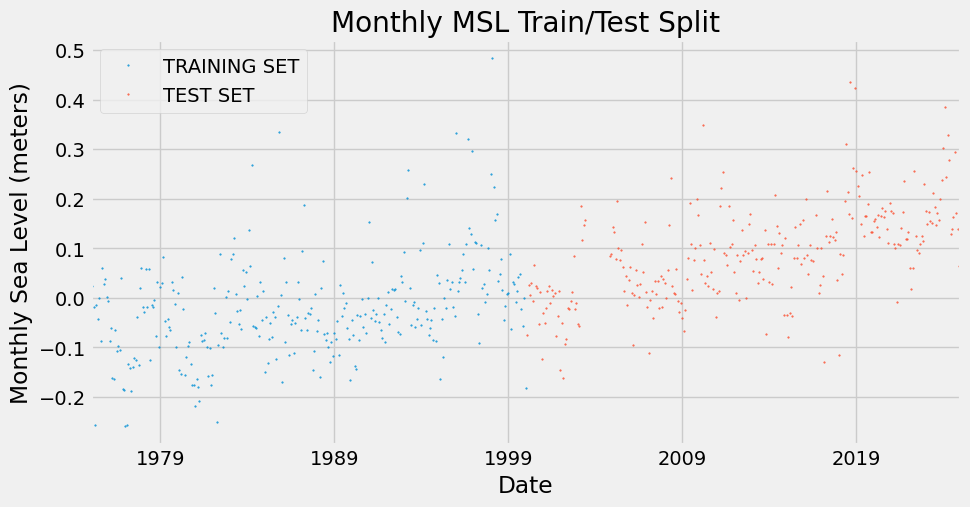

In [182]:
# Training data: all rows on or before the split date
df_train_prophet = prophet_df.loc[(prophet_df.index >= start_date) & (prophet_df.index <= split_date)].copy()

# Testing data: all rows after the split date and before end date
df_test_prophet = prophet_df.loc[(prophet_df.index > split_date) & (prophet_df.index <= end_date)].copy()

# Plot the training and testing data on the same figure for visual inspection
fig, ax = plt.subplots(figsize=(10, 5))
df_train_prophet['y'].plot(ax=ax, style='.', ms=1, label='TRAINING SET')
df_test_prophet['y'].plot(ax=ax, style='.', ms=1, label='TEST SET')

ax.set_title('Monthly MSL Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Sea Level (meters)')
ax.legend()
plt.show()

## Training the Model

In [183]:
%%time
model = Prophet()
model.fit(df_train_prophet)

19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 78.1 ms
Wall time: 252 ms


In [184]:
# The input DataFrame must have a 'ds' column with the dates to forecast
df_test_fcst = model.predict(df_test_prophet)

In [185]:
display(df_test_fcst.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-02-01,0.043874,-0.041876,0.181825,0.043874,0.043874,0.023246,0.023246,0.023246,0.023246,0.023246,0.023246,0.0,0.0,0.0,0.067120
1,2000-03-01,0.044303,-0.057269,0.181602,0.044303,0.044303,0.018512,0.018512,0.018512,0.018512,0.018512,0.018512,0.0,0.0,0.0,0.062814
2,2000-04-01,0.044760,-0.060331,0.168272,0.044760,0.044760,0.011397,0.011397,0.011397,0.011397,0.011397,0.011397,0.0,0.0,0.0,0.056158
3,2000-05-01,0.045204,-0.060678,0.163646,0.045203,0.045204,0.001423,0.001423,0.001423,0.001423,0.001423,0.001423,0.0,0.0,0.0,0.046626
4,2000-06-01,0.045661,-0.088249,0.143587,0.045661,0.045662,-0.017806,-0.017806,-0.017806,-0.017806,-0.017806,-0.017806,0.0,0.0,0.0,0.027855


In [186]:
df_test_fcst.columns


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

## Evaluating the Model

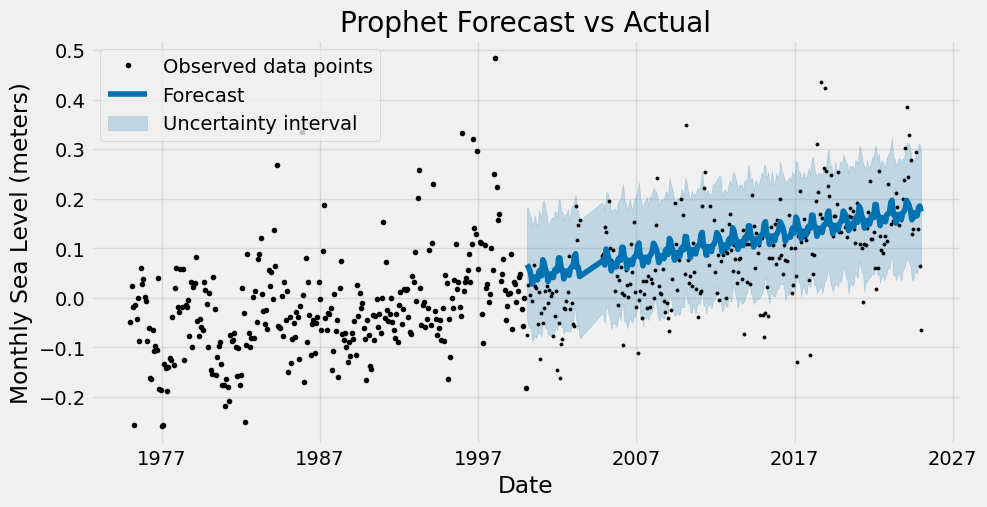

In [187]:
# Create a figure and axis for plotting, setting the figure size
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the Prophet forecast results on the specified axis
fig = model.plot(df_test_fcst, ax=ax)

# Plot the actual values from the test set as scatter points
ax.scatter(df_test_prophet['ds'], df_test_prophet['y'], color='black', s=5)

# Set the plot title
ax.set_title('Prophet Forecast vs Actual')
yaxis = ax.get_yaxis()
yaxis.set_label_text('Monthly Sea Level (meters)')
xaxis = ax.get_xaxis()
xaxis.set_label_text('Date')
ax.legend()
plt.show()

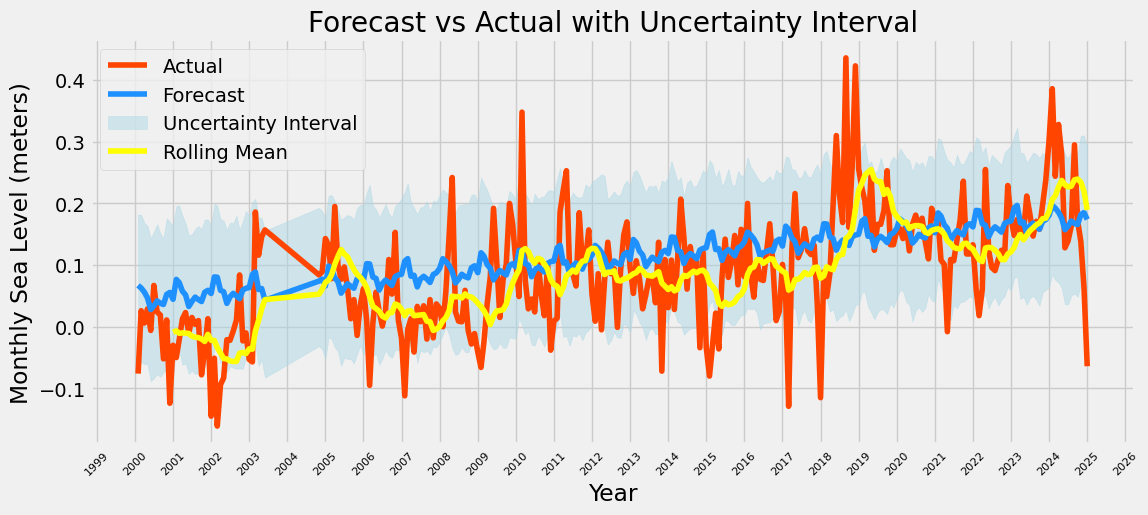

In [188]:
# Plot forecast with actuals and confidence intervals
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_test_prophet['ds'], df_test_prophet['y'], label='Actual', color='orangered')
ax.plot(df_test_fcst['ds'], df_test_fcst['yhat'], label='Forecast', color='dodgerblue')

# Plot the confidence interval
ax.fill_between(df_test_fcst['ds'], df_test_fcst['yhat_lower'], df_test_fcst['yhat_upper'], color='lightblue', alpha=0.5, label='Uncertainty Interval')

# Add rolling average
rolling_mean = df_test_prophet['y'].rolling(window=12).mean()
ax.plot(df_test_prophet['ds'], rolling_mean, label='Rolling Mean', color='yellow')

# Format the x-axis to show only years
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=8)

# Add axis titles
ax.set_xlabel('Year')
ax.set_ylabel('Monthly Sea Level (meters)')

# Legend
ax.legend()
ax.set_title('Forecast vs Actual with Uncertainty Interval')
plt.show()

In [193]:
# Calculate SMAPE
y_true = df_test_prophet['y'].values
y_pred = df_test_fcst['yhat'].values

# Filter out non-finite values
mask = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask]
y_pred = y_pred[mask]

# Compute SMAPE
smape = 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
print(f'SMAPE: {smape}')

SMAPE: 79.13782462377019


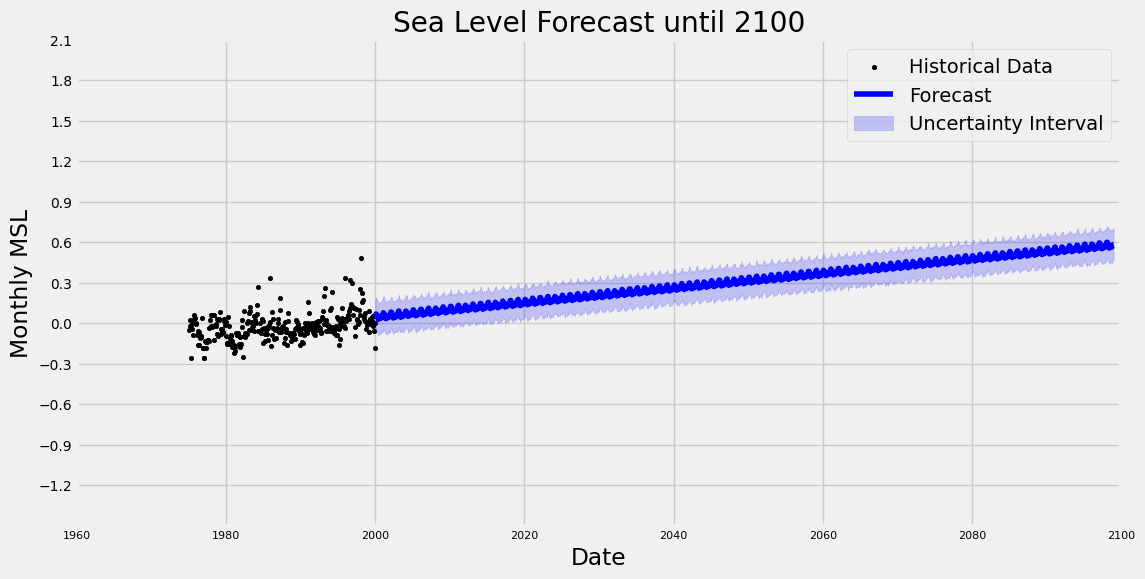

In [194]:
# Forecast
future_dates = model.make_future_dataframe(periods=(2100 - int(split_date.split("-")[0]) - 1) * 12, freq='MS')
forecast = model.predict(future_dates)

# Split history & future
history_end = split_date
forecast_future = forecast[forecast['ds'] >= history_end]
forecast_history = forecast[forecast['ds'] < history_end]

# Plot
plt.figure(figsize=(12,6))

# Historical data (actuals)
plt.scatter(model.history['ds'], model.history['y'], color='black', label='Historical Data', s=10)

# Forecast line for future
plt.plot(forecast_future['ds'], forecast_future['yhat'], color='blue', label='Forecast')

# Confidence interval for future
plt.fill_between(forecast_future['ds'],
                 forecast_future['yhat_lower'],
                 forecast_future['yhat_upper'],
                 color='blue', alpha=0.2, label='Uncertainty Interval')

# Labels & limits
plt.title('Sea Level Forecast until 2100')
plt.xlabel('Date')
plt.ylabel('Monthly MSL')
plt.ylim(-1.5, 2.1)
plt.yticks(np.arange(-1.2, 2.4, 0.3), fontsize=10)
plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('2100-01-01'))
plt.xticks(fontsize=8)
plt.legend()
plt.show()